In [173]:
!pip install fiftyone openimages torchmetrics

In [174]:
import fiftyone as fo
import fiftyone.zoo as foz
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import openimages.download as oi
import os
import shutil
import random
from torchmetrics.classification import ConfusionMatrix
from torchmetrics import Accuracy, Precision, Recall, F1Score

In [175]:
def download_images(images_path):
    image_class_idx = []
    image_paths = []
    limit = 333

    if os.path.exists(images_path):
      shutil.rmtree(images_path)

    os.makedirs(images_path, exist_ok=True)

    for class_name in classes:
        print(f"Downloading images for class: {class_name}")

        images = oi.download_dataset(
            dest_dir = images_path,
            class_labels = [class_name],
            limit=limit
        )

        image_class_idx.extend([classes.index(class_name)] * limit)

        class_folder = os.path.join(images_path, class_name.lower(), 'images')

        for image_filename in os.listdir(class_folder):
          if image_filename.endswith('.jpg'):
            image_paths.append(os.path.join(class_folder, image_filename))

    combined = list(zip(image_paths, image_class_idx))
    random.shuffle(combined)
    image_paths, image_class_idx = zip(*combined)

    return list(image_paths), list(image_class_idx)

In [176]:
class OpenImagesDataset(Dataset):
    def __init__(self, image_paths, label_indexes, transform):
        self.image_paths = image_paths
        self.label_indexes = label_indexes
        self.num_of_classes = len(set(label_indexes))
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label_index = self.label_indexes[idx]

        image = Image.open(img_path).convert('RGB')
        transformed_image = self.transform(image)

        class_one_hot = torch.zeros(self.num_of_classes)
        class_one_hot[label_index] = 1

        return transformed_image, class_one_hot

In [177]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()

        self.conv_stack = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(32 * 56 * 56, 512),
            nn.ReLU(),
            nn.Linear(512, 3)
        )

    def forward(self, x):
        return self.conv_stack(x)

In [178]:
def train_model(model, train_loader, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()
        acc_loss = 0.0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            acc_loss += loss.item()
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {acc_loss / len(train_loader)}')

In [225]:
def calculate_metrics(all_preds, all_labels, classes):
    num_of_labels = len(classes)
    accuracy_metric = Accuracy(task="multiclass", num_classes=num_of_labels, average='weighted')
    precision_metric = Precision(task="multiclass", num_classes=num_of_labels, average='weighted')
    recall_metric = Recall(task="multiclass", num_classes=num_of_labels, average='weighted')
    f1_metric = F1Score(task="multiclass", num_classes=num_of_labels, average='weighted')
    conf_matrix_metric = ConfusionMatrix(task="multiclass", num_classes=num_of_labels)

    accuracy = accuracy_metric(all_preds, all_labels)
    precision = precision_metric(all_preds, all_labels)
    recall = recall_metric(all_preds, all_labels)
    f1 = f1_metric(all_preds, all_labels)
    conf_matrix = conf_matrix_metric(all_preds, all_labels)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Confusion Matrix:\n{conf_matrix}")

    conf_matrix = conf_matrix_metric(all_preds, all_labels).cpu().numpy()
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()


In [192]:
def evaluate(model, data_loader, classes, device):
    all_preds = []
    all_labels = []
    model.eval()

    with torch.inference_mode():
        for image_batch, img_labels in data_loader:
            image_batch = image_batch.to(device)
            img_labels = img_labels.to(device)

            outputs = model(image_batch)

            _, predicted_outputs = torch.max(outputs, 1)
            _, true_labels = torch.max(img_labels, 1)

            all_preds.append(predicted_outputs)
            all_labels.append(true_labels)

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    calculate_metrics(all_preds, all_labels, classes)


In [181]:
classes = ["Car",
           "Tree",
           "Sink"]
images_path = "open_images"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [167]:
image_paths, image_labels = download_images(images_path)

100%|██████████| 333/333 [00:07<00:00, 42.11it/s]


100%|██████████| 333/333 [00:08<00:00, 41.02it/s]


100%|██████████| 333/333 [00:07<00:00, 42.09it/s]


In [182]:
split_idx = int(0.8 * len(image_paths))

train_dataset = OpenImagesDataset(image_paths[:split_idx], image_labels[:split_idx], transform)
test_dataset = OpenImagesDataset(image_paths[split_idx:], image_labels[split_idx:], transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [183]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NeuralNetwork()
model = model.to(device)

train_model(model, train_loader, device)

Epoch 1/10, Loss: 1.0968419599533081
Epoch 2/10, Loss: 1.079366602897644
Epoch 3/10, Loss: 1.0509292125701903
Epoch 4/10, Loss: 0.9954688906669616
Epoch 5/10, Loss: 0.9268973112106323
Epoch 6/10, Loss: 0.8793435764312744
Epoch 7/10, Loss: 0.8193848633766174
Epoch 8/10, Loss: 0.7897635388374329
Epoch 9/10, Loss: 0.7714957642555237
Epoch 10/10, Loss: 0.775266101360321


Accuracy: 0.6200
Precision: 0.6307
Recall: 0.6200
F1 Score: 0.6211
Confusion Matrix:
tensor([[37, 20,  3],
        [29, 34,  9],
        [10,  5, 53]])


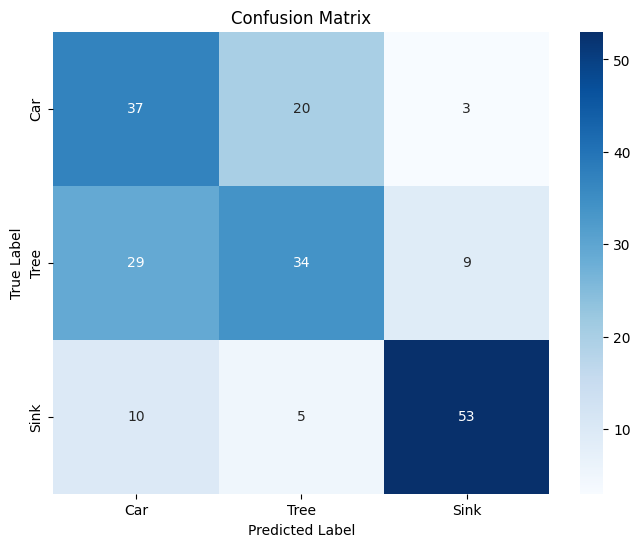

In [227]:
evaluate(model, test_loader, classes, device)

In [229]:
model_save_path = "trained_model.pth"
torch.save(model.state_dict(), model_save_path)